# Analysis 5 : Price/Volumes ~ FOMC Announcement #

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_ind
from pathlib import Path
DATA_ROOT = Path('../data')
RAW_ROOT = DATA_ROOT / 'raw'
OUTPUT_ROOT = Path('../output')
OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)


In [3]:
# import stata_setup, os, sys
# STATA_DIR = r"C:\Program Files\Stata18"      # Windows 
# # STATA_DIR = "/Applications/Stata"           # macOS 
# EDITION = "mp"     

# try:
#     stata_setup.config(STATA_DIR, EDITION)
# except RuntimeError as e:
#     if "already configured" not in str(e).lower():
#         raise
# from pystata import stata, config  # 
# stata.run('display "Stata is ready"')

## Load Data ##

In [4]:
# Step 1: Load the FOMC narrative data and high-frequency trading data
fomc_data = pd.read_csv(RAW_ROOT / 'FOMC_FFR.csv')
hft_data = pd.read_csv(RAW_ROOT / 'HFT_IRF.csv')

# Convert date/time columns to datetime format
# ?? CSV ? DATE ??? "1991/2/7"?TIME ??? "11:30:00"
fomc_data['DateTime'] = pd.to_datetime(fomc_data['DATE'] + ' ' + fomc_data['TIME'], format='%Y/%m/%d %H:%M:%S')

# ? DateTime ??????
cols = fomc_data.columns.tolist()
cols.insert(0, cols.pop(cols.index('DateTime')))
fomc_data = fomc_data[cols]

# ???? hft_data ? DateAndTime
hft_data['DateAndTime'] = pd.to_datetime(hft_data['DateAndTime'])

# ??????????
futures_columns = [
    'FF1_Price','FF1_Volume','FF2_Price','FF2_Volume',
    'ED2_Price','ED2_Volume','ED3_Price','ED3_Volume',
    'ED4_Price','ED4_Volume','2yr_price','2yr_Volume',
    '5yr_price','5yr_Volume','10yr_price','10yr_Volume'
]


In [5]:
def generate_non_fomc_dates(fomc_dates):
    """
    non-FOMC meeting dates are defined as Wednesdays that fall in the middle of the intervals between FOMC meetings,
    """
    fomc_dates = pd.to_datetime(fomc_dates).sort_values()
    non_fomc_dates = []
    
    for i in range(len(fomc_dates) - 1):
        start_date = fomc_dates.iloc[i]
        end_date = fomc_dates.iloc[i + 1]
        
        # calculate the interval in days
        interval_days = (end_date - start_date).days
        
        # only consider intervals longer than 14 days
        if interval_days > 14:
            # find the midpoint of the interval
            mid_date = start_date + pd.Timedelta(days=interval_days // 2)
            
            # find the nearest Wednesday to the midpoint
            days_to_wednesday = (2 - mid_date.weekday()) % 7  # 2 = Wednesday
            wednesday = mid_date + pd.Timedelta(days=days_to_wednesday)
            
            # make sure the Wednesday is at least 7 days away from both FOMC meetings
            # so that it doesn't fall too close to either meeting
            if start_date + pd.Timedelta(days=7) <= wednesday <= end_date - pd.Timedelta(days=7):
                non_fomc_dates.append(wednesday)
    
    return pd.Series(non_fomc_dates, name='DateTime')

# 生成非FOMC日期
non_fomc_dates = generate_non_fomc_dates(fomc_data['DateTime'])

In [6]:
# 根据日期设定正确的公告时间：2013年3月前是2:15 PM，之后是2:00 PM
def get_announcement_time(date):
    """根据日期返回正确的FOMC公告时间"""
    cutoff_date = pd.Timestamp('2013-03-01')
    if date < cutoff_date:
        return '14:15:00'  # 2:15 PM
    else:
        return '14:00:00'  # 2:00 PM

non_fomc_data = pd.DataFrame({
    'DateTime': non_fomc_dates,
    'DATE': non_fomc_dates.dt.strftime('%Y/%m/%d'),
    'TIME': non_fomc_dates.apply(get_announcement_time)
})

# 重新计算完整的DateTime，确保包含正确的时间
non_fomc_data['DateTime'] = pd.to_datetime(
    non_fomc_data['DATE'] + ' ' + non_fomc_data['TIME'], 
    format='%Y/%m/%d %H:%M:%S'
)

## Clean Emini Data ##

In [7]:
# Load and combine E-mini S&P 500 futures minute data

data_root = DATA_ROOT
es_paths = [
    RAW_ROOT / 'ES_1min_97to22.csv',
    RAW_ROOT / 'ES_1min_22to25.csv',
]

emini_parts = []
for path in es_paths:
    df = pd.read_csv(path)
    df['DateAndTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df = df[['DateAndTime', 'Close', 'Volume', 'Tick Count']].rename(
        columns={
            'Close': 'Emini_Price',
            'Volume': 'Emini_Volume',
            'Tick Count': 'Emini_Count',
        }
    )
    emini_parts.append(df)

emini_hft = (
    pd.concat(emini_parts, axis=0)
    .sort_values('DateAndTime')
    .drop_duplicates('DateAndTime', keep='last')
    .reset_index(drop=True)
)

for col in ['Emini_Price', 'Emini_Volume', 'Emini_Count']:
    emini_hft[col] = pd.to_numeric(emini_hft[col], errors='coerce')

emini_hft = emini_hft.dropna(subset=['DateAndTime']).sort_values('DateAndTime').reset_index(drop=True)

filled = []
for day, grp in emini_hft.groupby(emini_hft['DateAndTime'].dt.normalize(), sort=True):
    grp = grp.sort_values('DateAndTime').set_index('DateAndTime')
    full_index = pd.date_range(day, day + pd.Timedelta(days=1) - pd.Timedelta(minutes=1), freq='T')
    grp = grp.reindex(full_index)
    inserted = grp['Emini_Price'].isna()
    grp['Emini_Price'] = grp['Emini_Price'].ffill()
    grp.loc[inserted & grp['Emini_Price'].notna(), ['Emini_Volume', 'Emini_Count']] = 0.0
    grp[['Emini_Volume', 'Emini_Count']] = grp[['Emini_Volume', 'Emini_Count']].fillna(0.0)
    grp = grp.dropna(subset=['Emini_Price'])
    grp = grp.reset_index().rename(columns={'index': 'DateAndTime'})
    filled.append(grp)

emini_hft = pd.concat(filled, ignore_index=True).sort_values('DateAndTime').reset_index(drop=True)

emini_hft.to_csv(data_root / 'Emini_HFT.csv', index=False)
print('E-mini dataset prepared:', emini_hft['DateAndTime'].min(), '->', emini_hft['DateAndTime'].max(), 'rows:', len(emini_hft))


C:\Users\galax\AppData\Local\Temp\ipykernel_50680\4203256707.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(day, day + pd.Timedelta(days=1) - pd.Timedelta(minutes=1), freq='T')
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\4203256707.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(day, day + pd.Timedelta(days=1) - pd.Timedelta(minutes=1), freq='T')
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\4203256707.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(day, day + pd.Timedelta(days=1) - pd.Timedelta(minutes=1), freq='T')
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\4203256707.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(day, 

E-mini dataset prepared: 1997-09-10 01:01:00 -> 2025-06-25 23:59:00 rows: 10792875


In [8]:
# Align non-FOMC events with periods where market data exist
data_min = min(hft_data['DateAndTime'].min(), emini_hft['DateAndTime'].min())
data_max = max(hft_data['DateAndTime'].max(), emini_hft['DateAndTime'].max())
buffer = pd.Timedelta(days=2)  # largest window size (k=2)
non_fomc_data = (
    non_fomc_data[
        (non_fomc_data['DateTime'] >= data_min + buffer)
        & (non_fomc_data['DateTime'] <= data_max - buffer)
    ]
    .reset_index(drop=True)
)
print(f'Non-FOMC events after data alignment: {len(non_fomc_data)}')


Non-FOMC events after data alignment: 272


## Split Periods ##

In [9]:
from pathlib import Path
import pandas as pd
PDATA_ROOT = DATA_ROOT / 'periods'
# ===== Period boundaries =====
pre_end    = pd.Timestamp('2008-12-31')
zlb_start  = pd.Timestamp('2009-01-01')
zlb_end    = pd.Timestamp('2015-11-30')
post_start = pd.Timestamp('2015-12-01')

def split_and_cache(hft_data, emini_hft, fomc_data, output_dir, *,
                    force: bool = False,
                    src_files: dict | None = None):
    """Split datasets by ZLB periods, caching results on disk."""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    outs = {
        "pre_zlb_hft":    output_dir / "pre_zlb_hft.csv",
        "zlb_hft":        output_dir / "zlb_hft.csv",
        "post_zlb_hft":   output_dir / "post_zlb_hft.csv",
        "pre_zlb_emini":  output_dir / "pre_zlb_emini.csv",
        "zlb_emini":      output_dir / "zlb_emini.csv",
        "post_zlb_emini": output_dir / "post_zlb_emini.csv",
        "pre_zlb_fomc":   output_dir / "pre_zlb_fomc.csv",
        "zlb_fomc":       output_dir / "zlb_fomc.csv",
        "post_zlb_fomc":  output_dir / "post_zlb_fomc.csv",
    }
    parse_dates = {
        key: ['DateAndTime'] for key in outs if 'fomc' not in key
    }
    parse_dates.update({
        'pre_zlb_fomc': ['DateTime'],
        'zlb_fomc': ['DateTime'],
        'post_zlb_fomc': ['DateTime'],
    })

    def all_exist() -> bool:
        return all(path.exists() for path in outs.values())

    def outputs_newer_than_sources() -> bool:
        if not src_files:
            return True
        try:
            newest_src = max(Path(p).stat().st_mtime for p in src_files.values())
            oldest_out = min(Path(p).stat().st_mtime for p in outs.values())
            return oldest_out >= newest_src
        except FileNotFoundError:
            return False

    if all_exist() and not force and outputs_newer_than_sources():
        return {
            key: pd.read_csv(path, parse_dates=parse_dates.get(key))
            for key, path in outs.items()
        }

    pre_zlb_hft    = hft_data[hft_data['DateAndTime'] <= pre_end]
    zlb_hft        = hft_data[(hft_data['DateAndTime'] >= zlb_start) & (hft_data['DateAndTime'] <= zlb_end)]
    post_zlb_hft   = hft_data[hft_data['DateAndTime'] >= post_start]

    pre_zlb_emini  = emini_hft[emini_hft['DateAndTime'] <= pre_end]
    zlb_emini      = emini_hft[(emini_hft['DateAndTime'] >= zlb_start) & (emini_hft['DateAndTime'] <= zlb_end)]
    post_zlb_emini = emini_hft[emini_hft['DateAndTime'] >= post_start]

    def _split_fomc(df: pd.DataFrame):
        return (
            df[df['DateTime'] <= pre_end],
            df[(df['DateTime'] >= zlb_start) & (df['DateTime'] <= zlb_end)],
            df[df['DateTime'] >= post_start],
        )

    pre_zlb_fomc, zlb_fomc, post_zlb_fomc = _split_fomc(fomc_data)

    for key, df in {
        "pre_zlb_hft": pre_zlb_hft,
        "zlb_hft": zlb_hft,
        "post_zlb_hft": post_zlb_hft,
        "pre_zlb_emini": pre_zlb_emini,
        "zlb_emini": zlb_emini,
        "post_zlb_emini": post_zlb_emini,
        "pre_zlb_fomc": pre_zlb_fomc,
        "zlb_fomc": zlb_fomc,
        "post_zlb_fomc": post_zlb_fomc,
    }.items():
        df.to_csv(outs[key], index=False)

    return {
        "pre_zlb_hft":     pre_zlb_hft,
        "zlb_hft":         zlb_hft,
        "post_zlb_hft":    post_zlb_hft,
        "pre_zlb_emini":   pre_zlb_emini,
        "zlb_emini":       zlb_emini,
        "post_zlb_emini":  post_zlb_emini,
        "pre_zlb_fomc":    pre_zlb_fomc,
        "zlb_fomc":        zlb_fomc,
        "post_zlb_fomc":   post_zlb_fomc,
    }


In [10]:
# Split and cache datasets
splits = split_and_cache(
    hft_data,
    emini_hft,
    fomc_data,
    DATA_ROOT / 'periods',
    src_files={
        'hft': RAW_ROOT / 'HFT_IRF.csv',
        'emini_part1': RAW_ROOT / 'ES_1min_97to22.csv',
        'emini_part2': RAW_ROOT / 'ES_1min_22to25.csv',
        'fomc': RAW_ROOT / 'FOMC_FFR.csv',
    },
    force=False,
)
pre_zlb_hft = splits['pre_zlb_hft']
zlb_hft = splits['zlb_hft']
post_zlb_hft = splits['post_zlb_hft']
pre_zlb_emini = splits['pre_zlb_emini']
zlb_emini = splits['zlb_emini']
post_zlb_emini = splits['post_zlb_emini']
pre_zlb_fomc = splits['pre_zlb_fomc']
zlb_fomc = splits['zlb_fomc']
post_zlb_fomc = splits['post_zlb_fomc']


In [11]:
# 为每个时期分割非FOMC数据
def split_non_fomc_data(non_fomc_data):
    """按照相同的时期划分非FOMC数据"""
    pre_end = pd.Timestamp('2008-12-31')
    zlb_start = pd.Timestamp('2009-01-01')
    zlb_end = pd.Timestamp('2015-11-30')
    post_start = pd.Timestamp('2015-12-01')
    
    pre_zlb_non_fomc = non_fomc_data[non_fomc_data['DateTime'] <= pre_end]
    zlb_non_fomc = non_fomc_data[(non_fomc_data['DateTime'] >= zlb_start) & 
                                 (non_fomc_data['DateTime'] <= zlb_end)]
    post_zlb_non_fomc = non_fomc_data[non_fomc_data['DateTime'] >= post_start]
    
    return pre_zlb_non_fomc, zlb_non_fomc, post_zlb_non_fomc

pre_zlb_non_fomc, zlb_non_fomc, post_zlb_non_fomc = split_non_fomc_data(non_fomc_data)

print(f"生成的非FOMC日期总数: {len(non_fomc_data)}")
print(f"Pre-ZLB非FOMC日期: {len(pre_zlb_non_fomc)}")
print(f"ZLB非FOMC日期: {len(zlb_non_fomc)}")
print(f"Post-ZLB非FOMC日期: {len(post_zlb_non_fomc)}")

生成的非FOMC日期总数: 272
Pre-ZLB非FOMC日期: 150
ZLB非FOMC日期: 57
Post-ZLB非FOMC日期: 65


## Basic Setups ##

In [12]:
def calculate_cumulative_return(df, asset_col, baseline_price):
    """
    standardize the asset price series by calculating cumulative returns
    """
    df = df.copy()
    df['Return'] = df[asset_col].pct_change(fill_method=None)
    df['Return'] = df['Return'].replace([np.inf, -np.inf], np.nan).fillna(0.0) 
    df['CumReturn'] = (df[asset_col] / baseline_price) - 1
    return df



In [13]:
# Define a custom tick formatter for the x-axis
def format_tick(t):
    #   Set a reference start time to format the ticks
    ref = pd.Timestamp("2000-01-01 09:30")
    tick_time = ref + pd.Timedelta(minutes=t)
    # Determine which day the tick belongs to based on its value
    if t < 1440:
        return f"Day-1 {tick_time.strftime('%H:%M')}"
    elif t < 2880:
        return f"Day0 {tick_time.strftime('%H:%M')}"
    else:
        return f"Day+1 {tick_time.strftime('%H:%M')}"


##  Descriptive Statistics Framework  ##

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

In [15]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
DATA_ROOT = Path('../data')
DATA_ROOT.mkdir(parents=True, exist_ok=True)




def _t_sf(t_value, df):
    try:
        from scipy import stats
        return float(stats.t.sf(t_value, df))
    except Exception:
        if math.isinf(t_value):
            return 0.0
        return 0.5 * math.erfc(t_value / math.sqrt(2.0))


def _t_cdf(t_value, df):
    try:
        from scipy import stats
        return float(stats.t.cdf(t_value, df))
    except Exception:
        if math.isinf(t_value):
            return 0.0 if t_value < 0 else 1.0
        return 0.5 * (1.0 + math.erf(t_value / math.sqrt(2.0)))


def _compute_t_summary(samples):
    arr = np.asarray(samples, dtype=float)
    arr = arr[~np.isnan(arr)]
    n = arr.size
    if n == 0:
        return {'mean': np.nan, 't': np.nan, 'p_two': np.nan, 'n': 0}
    mean = float(arr.mean())
    if n < 2:
        return {'mean': mean, 't': np.nan, 'p_two': np.nan, 'n': int(n)}
    std = arr.std(ddof=1)
    if std == 0:
        t_stat = math.inf if mean > 0 else (-math.inf if mean < 0 else 0.0)
        two_sided = 0.0 if mean != 0 else 1.0
        return {'mean': mean, 't': t_stat, 'p_two': two_sided, 'n': int(n)}
    t_stat = mean / (std / math.sqrt(n))
    two_sided = 2.0 * _t_sf(abs(t_stat), n - 1)
    return {'mean': mean, 't': t_stat, 'p_two': two_sided, 'n': int(n)}


def _format_cell(value, pvalue, direction=None, value_fmt=",.0f", p_fmt=".3f"):
    if pd.isna(value):
        value_str = 'NA'
    else:
        value_str = format(value, value_fmt)
    if pd.isna(pvalue):
        p_str = 'p=NA'
    else:
        if pvalue < 0.001:
            p_str = 'p<0.001'
        else:
            p_str = f"p={pvalue:{p_fmt}}"
    if direction:
        if direction == '>':
            p_str = f"{p_str} (>0)"
        elif direction == '<':
            p_str = f"{p_str} (<0)"
        elif direction == '=':
            p_str = f"{p_str} (=0)"
    return f"{value_str}\n{p_str}"


def _latex_escape(text):
    replacements = {
        '_': r'\\_',
        '%': r'\\%',
        '&': r'\\&',
    }
    out = str(text)
    for key, val in replacements.items():
        out = out.replace(key, val)
    return out


def _format_cell_for_latex(cell):
    if isinstance(cell, str) and '\\n' in cell:
        top, bottom = cell.split('\\n', 1)
        return (
            r'\\begin{tabular}[c]{@{}c@{}}'
            + _latex_escape(top)
            + r'\\\\scriptsize{'
            + _latex_escape(bottom)
            + r'}\\end{tabular}'
        )
    return _latex_escape(cell)


def _time_window_mask(tod_array, window_radius, announcement_tod):
    arr = np.asarray(tod_array, dtype=int)
    radius = abs(int(window_radius))
    if radius >= 720:
        return np.ones_like(arr, dtype=bool)
    lower = (announcement_tod - radius) % 1440
    upper = (announcement_tod + radius) % 1440
    if lower <= upper:
        return (arr >= lower) & (arr <= upper)
    return (arr >= lower) | (arr <= upper)


def _prepare_volume_long(vol_input):
    if isinstance(vol_input, pd.DataFrame):
        df_wide = vol_input.copy()
        df_wide.index.name = 'MinuteFromStart'
        columns = list(df_wide.columns)
        if isinstance(df_wide.columns, pd.MultiIndex):
            columns = ['_'.join(str(part) for part in tup if str(part)) for tup in columns]
        columns = [str(col) for col in columns]
        if pd.Index(columns).duplicated().any():
            counts = {}
            adjusted = []
            for col in columns:
                counts[col] = counts.get(col, 0) + 1
                if counts[col] == 1:
                    adjusted.append(col)
                else:
                    adjusted.append(f"{col}__{counts[col]}")
            columns = adjusted
        df_wide.columns = columns
        long = df_wide.stack(dropna=False).reset_index()
        long.columns = ['MinuteFromStart', 'Event', 'Volume']
    else:
        s = pd.Series(vol_input, copy=True)
        s.index.name = 'MinuteFromStart'
        long = s.rename('Volume').reset_index()
        long['Event'] = 0
    long['MinuteFromStart'] = pd.to_numeric(long['MinuteFromStart'], errors='coerce')
    long['Volume'] = pd.to_numeric(long['Volume'], errors='coerce')
    long = long.dropna(subset=['MinuteFromStart'])
    long['MinuteInt'] = np.rint(long['MinuteFromStart']).astype(int)
    long['tod'] = (long['MinuteInt'] % 1440).astype(int)
    return long


def _describe_vector(values):
    arr = np.asarray(values, dtype=float)
    arr = arr[~np.isnan(arr)]
    n = arr.size
    if n == 0:
        return {
            'Mean': np.nan,
            'St. Dev': np.nan,
            'P25': np.nan,
            'P50': np.nan,
            'P75': np.nan,
            'No. Obs': 0,
        }
    return {
        'Mean': float(arr.mean()),
        'St. Dev': float(arr.std(ddof=1)) if n > 1 else 0.0,
        'P25': float(np.percentile(arr, 25)),
        'P50': float(np.percentile(arr, 50)),
        'P75': float(np.percentile(arr, 75)),
        'No. Obs': int(n),
    }


def _format_number(value, decimals):
    if pd.isna(value):
        return ''
    return f"{value:,.{decimals}f}"



def _write_latex_table_multi(df, caption, label, filepath=None, decimals=None, default_decimals=0):
    decimals = decimals or {}
    if not isinstance(df.columns, pd.MultiIndex):
        df = df.copy()
        df.columns = pd.MultiIndex.from_product([df.columns, ['Value']])
    top_labels = []
    for lbl in df.columns.get_level_values(0):
        if lbl not in top_labels:
            top_labels.append(lbl)
    metrics_per_label = {lbl: [col[1] for col in df.columns if col[0] == lbl] for lbl in top_labels}
    lines = [
        r'\begin{table}[!htbp]\centering',
        f'\\caption{{{caption}}}',
        f'\\label{{{label}}}',
        r'\begin{tabular}{l' + 'c' * df.shape[1] + '}',
        r'\hline',
    ]
    header_top = ['']
    for lbl in top_labels:
        span = len(metrics_per_label[lbl])
        header_top.append(f'\\multicolumn{{{span}}}{{c}}{{{_latex_escape(lbl)}}}')
    lines.append(' & '.join(header_top) + ' \\')
    header_bottom = ['']
    for lbl in top_labels:
        for metric in metrics_per_label[lbl]:
            header_bottom.append(_latex_escape(metric))
    lines.append(' & '.join(header_bottom) + ' \\')
    lines.append(r'\hline')
    for idx in df.index:
        row = [_latex_escape(str(idx))]
        for lbl in top_labels:
            for metric in metrics_per_label[lbl]:
                value = df.loc[idx, (lbl, metric)]
                decimals_here = decimals.get(metric, default_decimals)
                row.append(_format_number(value, decimals_here))
        lines.append(' & '.join(row) + ' \\')
    lines.extend([
        r'\hline',
        r'\end{tabular}',
        r'\end{table}',
    ])
    content = '\n'.join(lines)
    if filepath is not None:
        Path(filepath).write_text(content, encoding='utf-8')
    return content


def summarize_fomc_daily_volume(
    vol_input,
    k,
    window_days=2,
    make_tables=False,
    out_prefix=None
):
    """Compute daily FOMC week volume statistics and return a formatted table."""
    long = _prepare_volume_long(vol_input)
    k_int = int(k)
    window_days = int(window_days)
    focus_days = list(range(-window_days, window_days + 1))
    long['DayIndex'] = (long['MinuteInt'] // 1440) - k_int
    filtered = long[long['DayIndex'].isin(focus_days)].copy()
    if filtered.empty:
        empty_columns = pd.MultiIndex.from_product([
            [f'FOMC_week_Day ({d:+d})' for d in focus_days],
            ['Mean', 'St. Dev', 'P25', 'P50', 'P75', 'No. Obs'],
        ])
        empty_table = pd.DataFrame(index=['Avg Daily Volume', 'Diff_Vol (Ann - Day)', '# Obs'], columns=empty_columns)
        return {
            'table': empty_table,
            'daily_totals': pd.DataFrame(),
            'per_day_stats': {},
            'diff_means': {},
        }
    daily_totals = (
        filtered.groupby(['Event', 'DayIndex'])['Volume']
        .sum(min_count=1)
        .unstack('DayIndex')
        .reindex(columns=focus_days)
    )
    column_labels = {
        -2: 'FOMC_week_Day (-2)',
        -1: 'FOMC_week_Day (-1)',
        0: 'FOMC_week_Day (0)',
        1: 'FOMC_week_Day (+1)',
        2: 'FOMC_week_Day (+2)',
    }
    metrics = ['Mean', 'St. Dev', 'P25', 'P50', 'P75', 'No. Obs']
    columns = []
    labels_in_use = []
    for day in focus_days:
        label = column_labels.get(day, f'FOMC_week_Day ({day:+d})')
        labels_in_use.append(label)
        for metric in metrics:
            columns.append((label, metric))
    stats_table = pd.DataFrame(np.nan, index=['Avg Daily Volume', 'Diff_Vol (Ann - Day)', '# Obs'], columns=pd.MultiIndex.from_tuples(columns))
    per_day_stats = {}
    diff_means = {}
    base_series = daily_totals[0] if 0 in daily_totals.columns else pd.Series(dtype=float)
    for day, label in zip(focus_days, labels_in_use):
        series = daily_totals[day] if day in daily_totals.columns else pd.Series(dtype=float)
        stats = _describe_vector(series)
        per_day_stats[day] = stats
        for metric in metrics:
            stats_table.loc['Avg Daily Volume', (label, metric)] = stats.get(metric, np.nan)
        diff_value = np.nan
        if day == 0:
            diff_value = 0.0 if stats['No. Obs'] > 0 else np.nan
        elif not base_series.empty:
            diffs = (base_series - series).dropna()
            diff_value = float(diffs.mean()) if not diffs.empty else np.nan
        diff_means[day] = diff_value
        stats_table.loc['Diff_Vol (Ann - Day)', (label, 'Mean')] = diff_value
        stats_table.loc['# Obs', (label, 'Mean')] = stats.get('No. Obs', np.nan)
    return {
        'table': stats_table,
        'daily_totals': daily_totals,
        'per_day_stats': per_day_stats,
        'diff_means': diff_means,
    }


def analyze_volume_periodicity(
    vol_input,
    k,
    window_list=(15, 30, 60, 120, 720),
    market_open_min=570,
    market_close_min=960,
    exclude_minutes=30,
    make_tables=False,
    out_prefix=None
):
    """Compute per-minute intraday window statistics for announcement and non-announcement days."""
    long = _prepare_volume_long(vol_input)
    k_int = int(k)
    window_list = [abs(int(w)) for w in window_list]
    long['DayIndex'] = (long['MinuteInt'] // 1440) - k_int
    open_start = max(0, market_open_min - exclude_minutes)
    open_end = min(1440, market_open_min + exclude_minutes)
    close_start = max(0, market_close_min - exclude_minutes)
    close_end = min(1440, market_close_min + exclude_minutes)
    excl_mask = (
        ((long['tod'] >= open_start) & (long['tod'] < open_end))
        | ((long['tod'] >= close_start) & (long['tod'] < close_end))
    )
    use = long.loc[~excl_mask].copy()
    use = use.dropna(subset=['Volume'])
    if use.empty:
        empty_columns = pd.MultiIndex.from_product([
            [f'±{w}m' for w in window_list],
            ['Mean', 'St. Dev', 'P25', 'P50', 'P75', 'No. Obs'],
        ])
        empty = pd.DataFrame(index=['Ann Window Volume', 'Diff (Ann - Non)', '# Obs'], columns=empty_columns)
        return {
            'volume_table': empty,
            'variance_table': empty,
            'volume_summary': pd.DataFrame(),
            'variance_summary': pd.DataFrame(),
            'per_event_window_stats': pd.DataFrame(),
        }
    announcement_tod = 14 * 60
    window_records = []
    for (event, day), grp in use.groupby(['Event', 'DayIndex']):
        vols = grp['Volume'].astype(float).to_numpy()
        tods = grp['tod'].to_numpy()
        for w in window_list:
            mask = _time_window_mask(tods, w, announcement_tod)
            if mask.any():
                selected = vols[mask]
                valid = selected[~np.isnan(selected)]
                if valid.size:
                    avg = float(valid.mean())
                    var = float(valid.var(ddof=1)) if valid.size > 1 else np.nan
                    count = int(valid.size)
                else:
                    avg = np.nan
                    var = np.nan
                    count = 0
            else:
                avg = np.nan
                var = np.nan
                count = 0
            window_records.append({
                'Event': event,
                'DayIndex': int(day),
                'Window': int(w),
                'AverageVolume': avg,
                'Variance': var,
                'Count': count,
            })
    window_stats = pd.DataFrame(window_records)
    if window_stats.empty:
        empty_columns = pd.MultiIndex.from_product([
            [f'±{w}m' for w in window_list],
            ['Mean', 'St. Dev', 'P25', 'P50', 'P75', 'No. Obs'],
        ])
        empty = pd.DataFrame(index=['Ann Window Volume', 'Diff (Ann - Non)', '# Obs'], columns=empty_columns)
        return {
            'volume_table': empty,
            'variance_table': empty,
            'volume_summary': pd.DataFrame(),
            'variance_summary': pd.DataFrame(),
            'per_event_window_stats': pd.DataFrame(),
        }
    ann_stats = window_stats[window_stats['DayIndex'] == 0].rename(columns={'Count': 'AnnCount'})
    non_stats = window_stats[window_stats['DayIndex'] != 0]
    non_avg = (
        non_stats.groupby(['Event', 'Window'])['AverageVolume']
        .mean()
        .reset_index(name='AverageVolume_non')
    )
    non_var = (
        non_stats.groupby(['Event', 'Window'])['Variance']
        .mean()
        .reset_index(name='Variance_non')
    )
    non_days = (
        non_stats.groupby(['Event', 'Window'])['AverageVolume']
        .count()
        .reset_index(name='NonDays')
    )
    merged = ann_stats.merge(non_avg, on=['Event', 'Window'], how='left')
    merged = merged.merge(non_var, on=['Event', 'Window'], how='left')
    merged = merged.merge(non_days, on=['Event', 'Window'], how='left')
    window_label_map = {
        15: '±15m',
        30: '±30m',
        60: '±1h',
        120: '±2h',
        720: '±12h',
    }
    metrics = ['Mean', 'St. Dev', 'P25', 'P50', 'P75', 'No. Obs']
    tuples = []
    labels_in_use = []
    for w in window_list:
        label = window_label_map.get(w, f'±{w}m')
        labels_in_use.append(label)
        for metric in metrics:
            tuples.append((label, metric))
    volume_table = pd.DataFrame(np.nan, index=['Ann Window Volume', 'Diff (Ann - Non)', '# Obs'], columns=pd.MultiIndex.from_tuples(tuples))
    variance_table = volume_table.copy()
    volume_summary_records = []
    variance_summary_records = []
    for w, label in zip(window_list, labels_in_use):
        subset = merged[merged['Window'] == w]
        ann_vals = subset['AverageVolume'].dropna()
        diff_vals = (subset['AverageVolume'] - subset['AverageVolume_non']).dropna()
        stats = _describe_vector(ann_vals)
        for metric in metrics:
            volume_table.loc['Ann Window Volume', (label, metric)] = stats.get(metric, np.nan)
        volume_table.loc['Diff (Ann - Non)', (label, 'Mean')] = float(diff_vals.mean()) if not diff_vals.empty else np.nan
        volume_table.loc['# Obs', (label, 'Mean')] = stats.get('No. Obs', np.nan)
        volume_summary_records.append({
            'window_min': w,
            'label': label,
            **stats,
            'DiffMean': float(diff_vals.mean()) if not diff_vals.empty else np.nan,
        })
        ann_var_vals = subset['Variance'].dropna()
        diff_var_vals = (subset['Variance'] - subset['Variance_non']).dropna()
        var_stats = _describe_vector(ann_var_vals)
        for metric in metrics:
            variance_table.loc['Ann Window Volume', (label, metric)] = var_stats.get(metric, np.nan)
        variance_table.loc['Diff (Ann - Non)', (label, 'Mean')] = float(diff_var_vals.mean()) if not diff_var_vals.empty else np.nan
        variance_table.loc['# Obs', (label, 'Mean')] = var_stats.get('No. Obs', np.nan)
        variance_summary_records.append({
            'window_min': w,
            'label': label,
            **var_stats,
            'DiffMean': float(diff_var_vals.mean()) if not diff_var_vals.empty else np.nan,
        })
    volume_summary = pd.DataFrame(volume_summary_records).set_index('window_min') if volume_summary_records else pd.DataFrame()
    variance_summary = pd.DataFrame(variance_summary_records).set_index('window_min') if variance_summary_records else pd.DataFrame()
    per_event_window_stats = merged[
        ['Event', 'Window', 'AnnCount', 'NonDays', 'AverageVolume', 'AverageVolume_non', 'Variance', 'Variance_non']
    ].copy()
    return {
        'volume_table': volume_table,
        'variance_table': variance_table,
        'volume_summary': volume_summary,
        'variance_summary': variance_summary,
        'per_event_window_stats': per_event_window_stats,
    }


def _persist_volume_outputs_enhanced(asset, period, k, daily_table, intraday_volume_table, 
                                   intraday_variance_table, fomc_type='fomc'):
    """
    增强版输出函数，支持fomc和nonfomc两种类型
    fomc_type: 'fomc' 或 'nonfomc'
    """
    asset_str = str(asset)
    asset_dir = DATA_ROOT / asset_str
    asset_dir.mkdir(parents=True, exist_ok=True)
    
    # 如果是nonfomc类型，创建子文件夹
    if fomc_type == 'nonfomc':
        output_dir = asset_dir / 'nonfomc'
        output_dir.mkdir(parents=True, exist_ok=True)
    else:
        output_dir = asset_dir
    
    period_str = str(period) if period else 'period'
    safe_period = period_str.replace(' ', '_')
    
    # 文件命名加上类型前缀
    prefix = f"{fomc_type}_" if fomc_type == 'nonfomc' else ""
    excel_path = output_dir / f'{prefix}{asset_str}_k{k}_{safe_period}.xlsx'
    
    with pd.ExcelWriter(excel_path) as writer:
        daily_table.to_excel(writer, sheet_name='daily volume')
        intraday_volume_table.to_excel(writer, sheet_name='intraday volume')
        intraday_variance_table.to_excel(writer, sheet_name='intraday volume variance')
    
    latex_dir = output_dir / 'latex'
    latex_dir.mkdir(parents=True, exist_ok=True)
    
    # LaTeX标题调整
    event_type = "Non-FOMC" if fomc_type == 'nonfomc' else "FOMC"
    
    daily_tex = _write_latex_table_multi(
        daily_table,
        f'Average daily volumes around {event_type} announcement',
        f'tab:{asset_str}_{safe_period}_{fomc_type}_daily_volume',
        filepath=None,
        decimals={'Mean': 0, 'St. Dev': 0, 'P25': 0, 'P50': 0, 'P75': 0, 'No. Obs': 0},
        default_decimals=0,
    )
    
    intraday_vol_tex = _write_latex_table_multi(
        intraday_volume_table,
        f'Intraday {event_type} announcement window volume (per-minute averages)',
        f'tab:{asset_str}_{safe_period}_{fomc_type}_intraday_volume',
        filepath=None,
        decimals={'Mean': 3, 'St. Dev': 3, 'P25': 3, 'P50': 3, 'P75': 3, 'No. Obs': 0},
        default_decimals=3,
    )
    
    intraday_var_tex = _write_latex_table_multi(
        intraday_variance_table,
        f'Intraday {event_type} announcement window variance',
        f'tab:{asset_str}_{safe_period}_{fomc_type}_intraday_variance',
        filepath=None,
        decimals={'Mean': 6, 'St. Dev': 6, 'P25': 6, 'P50': 6, 'P75': 6, 'No. Obs': 0},
        default_decimals=6,
    )
    
    latex_path = latex_dir / f'{prefix}{safe_period}.tex'
    latex_content = '\n\n'.join([daily_tex, intraday_vol_tex, intraday_var_tex])
    latex_path.write_text(latex_content, encoding='utf-8')
    
    return {
        'excel_path': excel_path,
        'latex_path': latex_path,
        'output_dir': output_dir,
        'latex_dir': latex_dir,
    }

##  Return/Volume Plots Framework ##

In [16]:
def plot_fomc_k_window_enhanced(hft_input, fomc_input, k=1, asset='', period='', 
                               extra_metrics=None, fomc_type='fomc'):
    """
    增强版绘图函数，支持FOMC和非FOMC分析
    fomc_type: 'fomc' 或 'nonfomc'
    """
    from pathlib import Path

    extra_metrics = extra_metrics or {}
    metric_series = {name: [] for name in extra_metrics}

    fomc_list = fomc_input['DateTime']
    all_cr_list = []
    all_vol_list = []
    price_col = asset + '_Price'
    volume_col = asset + '_Volume'

    window_start_reference = lambda dt: dt.normalize() - pd.Timedelta(days=k)
    window_end_reference = lambda dt: dt.normalize() + pd.Timedelta(days=k + 1)

    time_length_hours = 24 * (2 * k + 1)
    total_minutes = int(time_length_hours * 60)

    for fomc_dt in fomc_list:
        window_start = window_start_reference(fomc_dt)
        window_end = window_end_reference(fomc_dt)

        event_df = hft_input[(hft_input['DateAndTime'] >= window_start) & 
                           (hft_input['DateAndTime'] < window_end)].copy()
        if event_df.empty:
            continue

        baseline_row = event_df.iloc[(event_df['DateAndTime'] - window_start).abs().argmin()]
        baseline_price = baseline_row[price_col]
        if pd.isna(baseline_price) or baseline_price <= 0:
            print(f'Skipping {fomc_type} event at {fomc_dt} due to invalid baseline price: {baseline_price}.')
            continue

        event_df = calculate_cumulative_return(event_df, price_col, baseline_price)
        event_df['MinuteFromStart'] = (event_df['DateAndTime'] - window_start).dt.total_seconds() / 60
        event_df.set_index('MinuteFromStart', inplace=True)

        all_cr_list.append(event_df['CumReturn'])
        all_vol_list.append(event_df[volume_col])
        for metric_name, column in extra_metrics.items():
            if column in event_df.columns:
                metric_series[metric_name].append(event_df[column])

    if not all_cr_list:
        print(f'No valid {fomc_type} events found!')
        return None

    merged_cr = pd.concat(all_cr_list, axis=1)
    avg_cr = merged_cr.mean(axis=1)
    std_cr = merged_cr.std(axis=1)
    n = merged_cr.shape[1]

    ci_upper = avg_cr + 1.96 * std_cr / np.sqrt(n)
    ci_lower = avg_cr - 1.96 * std_cr / np.sqrt(n)

    avg_cr = avg_cr.sort_index()
    ci_upper = ci_upper.sort_index()
    ci_lower = ci_lower.sort_index()
    full_minutes = np.arange(0, total_minutes + 1)
    avg_cr = avg_cr.reindex(full_minutes, method='nearest')
    ci_upper = ci_upper.reindex(full_minutes, method='nearest')
    ci_lower = ci_lower.reindex(full_minutes, method='nearest')

    avg_cr_bps = avg_cr * 10000
    ci_upper_bps = ci_upper * 10000
    ci_lower_bps = ci_lower * 10000

    merged_vol = pd.concat(all_vol_list, axis=1)
    avg_vol = merged_vol.mean(axis=1)
    avg_vol = avg_vol.sort_index().reindex(full_minutes, method='nearest')

    fig, ax1 = plt.subplots(figsize=(18, 8))

    ax1.plot(full_minutes, avg_cr_bps, color='blue', linewidth=1, label='Avg CumReturn (bps)')
    ax1.fill_between(full_minutes, ci_lower_bps, ci_upper_bps, color='blue', alpha=0.2, label='95% CI')
    ax1.set_ylabel('Cumulative Return (bps)', fontsize=12)
    ax1.set_xlabel('Time', fontsize=12)

    ax2 = ax1.twinx()
    ax2.bar(full_minutes, avg_vol, width=1.0, color='gray', alpha=0.3, label='Avg Volume')
    ax2.set_ylabel('Volume', fontsize=12)

    announcement_minute = int(k * 1440 + 840)
    event_label = 'Non-FOMC Event' if fomc_type == 'nonfomc' else 'FOMC Announcement'
    ax1.axvline(x=announcement_minute, color='red', linestyle='--', linewidth=0.5, label=event_label)

    num_days = 2 * k + 1
    for i in range(1, num_days):
        day_boundary = i * 1440
        ax1.axvline(x=day_boundary, color='black', linewidth=1)

    ax1.xaxis.set_major_locator(MultipleLocator(120))
    ax1.xaxis.set_minor_locator(MultipleLocator(60))
    ax1.tick_params(axis='x', which='major', length=10, rotation=45)
    ax1.tick_params(axis='x', which='minor', length=5)

    def time_formatter(x, pos):
        t = x % 1440
        hours = int(t // 60)
        minutes = int(t % 60)
        return f'{hours:02d}:{minutes:02d}'

    ax1.xaxis.set_major_formatter(FuncFormatter(time_formatter))

    ax_top = ax1.twiny()
    ax_top.set_xlim(ax1.get_xlim())
    day_centers = [i * 1440 + 720 for i in range(num_days)]
    day_labels = [f'Day {i - k}' for i in range(num_days)]
    ax_top.set_xticks(day_centers)
    ax_top.set_xticklabels(day_labels)
    ax_top.set_xlabel('Day', fontsize=12)

    ax1.set_xlim(0, total_minutes)

    event_type = 'Non-FOMC' if fomc_type == 'nonfomc' else 'FOMC'
    fig.suptitle(f'{event_type} +/-{k} Days: {price_col} & {volume_col} in {period}_Period', fontsize=16)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid(True)
    plt.tight_layout()

    asset_str = str(asset) if asset else 'asset'
    period_str = str(period) if period else 'period'
    safe_period = period_str.replace(' ', '_')
    asset_dir = DATA_ROOT / asset_str
    
    # 如果是nonfomc类型，保存到子文件夹
    if fomc_type == 'nonfomc':
        save_dir = asset_dir / 'nonfomc'
        save_dir.mkdir(parents=True, exist_ok=True)
        prefix = 'nonfomc_'
    else:
        save_dir = asset_dir
        save_dir.mkdir(parents=True, exist_ok=True)
        prefix = ''

    fig_path = save_dir / f'{prefix}fomc_window_k{k}_{safe_period}.png'
    fig.savefig(fig_path, dpi=200, bbox_inches='tight')
    print(f'Saved figure: {fig_path}')
    plt.show()

    cr_table = pd.DataFrame({
        'MinuteFromStart': full_minutes,
        'Average_CR_bps': avg_cr_bps.values,
        'CI_Lower_bps': ci_lower_bps.values,
        'CI_Upper_bps': ci_upper_bps.values,
        'volume': avg_vol.values,
    })
    cr_out = save_dir / f'{prefix}{asset_str}_in_{k}_cr_{safe_period}.csv'
    cr_table.to_csv(cr_out, index=False)
    print(f'Saved CR table: {cr_out}')

    daily_summary = summarize_fomc_daily_volume(
        merged_vol,
        k=k,
        window_days=2,
        make_tables=False,
    )
    intraday_summary = analyze_volume_periodicity(
        merged_vol,
        k=k,
        window_list=(15, 30, 60, 120, 720),
        make_tables=False,
    )

    persist_info = _persist_volume_outputs_enhanced(
        asset_str,
        period_str,
        k,
        daily_summary['table'],
        intraday_summary['volume_table'],
        intraday_summary['variance_table'],
        fomc_type=fomc_type,
    )
    print(f"Saved summary workbook: {persist_info['excel_path']}")
    print(f"Saved LaTeX bundle: {persist_info['latex_path']}")

    # 处理额外指标
    extra_exports = {}
    if extra_metrics:
        for metric_name, series_list in metric_series.items():
            if not series_list:
                continue
            merged_metric = pd.concat(series_list, axis=1)
            metric_period = f"{period_str}_{metric_name}".strip('_')
            metric_daily = summarize_fomc_daily_volume(
                merged_metric,
                k=k,
                window_days=2,
                make_tables=False,
            )
            metric_intraday = analyze_volume_periodicity(
                merged_metric,
                k=k,
                window_list=(15, 30, 60, 120, 720),
                make_tables=False,
            )
            metric_export = _persist_volume_outputs_enhanced(
                asset_str,
                metric_period,
                k,
                metric_daily['table'],
                metric_intraday['volume_table'],
                metric_intraday['variance_table'],
                fomc_type=fomc_type,
            )
            print(f"Saved extras ({metric_name}) workbook: {metric_export['excel_path']}")
            print(f"Saved extras ({metric_name}) LaTeX: {metric_export['latex_path']}")
            extra_exports[metric_name] = {
                'daily_summary': metric_daily,
                'intraday_summary': metric_intraday,
                'export_paths': metric_export,
            }

    return {
        'figure_path': fig_path,
        'cr_table_path': cr_out,
        'daily_summary': daily_summary,
        'intraday_summary': intraday_summary,
        'export_paths': persist_info,
        'extra_metrics': extra_exports,
    }

###  Example Plot ###

### ========== Load Data ==========

### ========== Example ==========

```python
plot_fomc_k_window(hft_input=hft_data, fomc_input=fomc_data,k=1, asset='FF1',period='Total')
plot_fomc_k_window(hft_input=hft_data, fomc_input=fomc_data,k=1, asset='ED3',period='Total')
plot_fomc_k_window(hft_input=hft_data, fomc_input=fomc_data,k=1, asset='2yr',period='Total')
```


Skipping fomc event at 2022-06-15 14:00:00 due to invalid baseline price: nan.
Skipping fomc event at 2022-05-04 14:00:00 due to invalid baseline price: nan.
Saved figure: ..\data\ED3\fomc_window_k0_Total.png


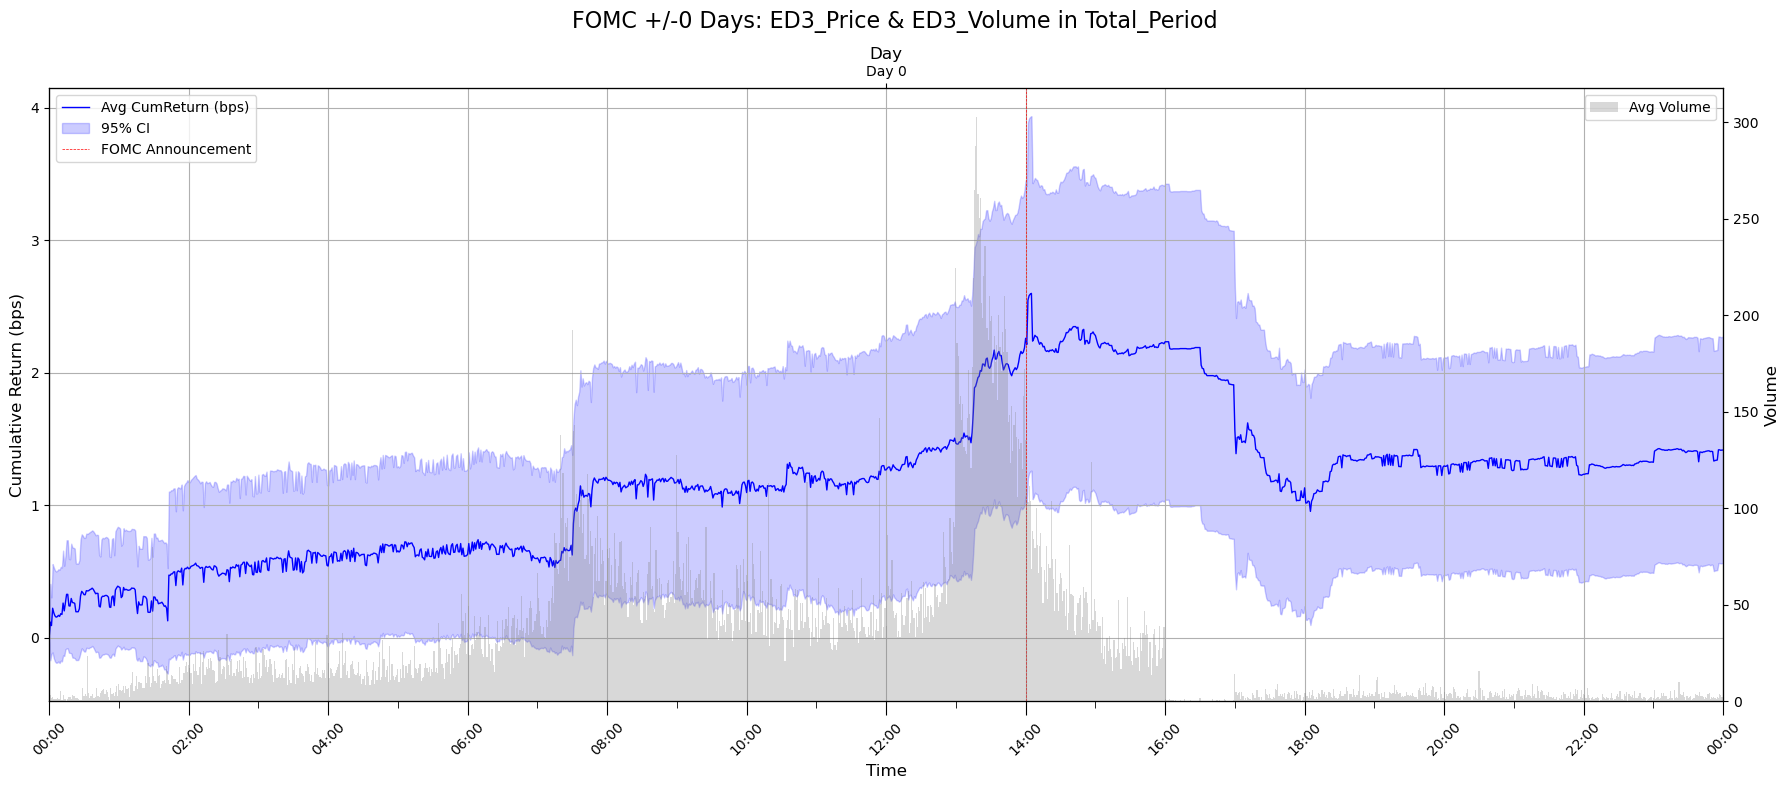

Saved CR table: ..\data\ED3\ED3_in_0_cr_Total.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_50680\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\ED3\ED3_k0_Total.xlsx
Saved LaTeX bundle: ..\data\ED3\latex\Total.tex


{'figure_path': WindowsPath('../data/ED3/fomc_window_k0_Total.png'),
 'cr_table_path': WindowsPath('../data/ED3/ED3_in_0_cr_Total.csv'),
 'daily_summary': {'table':                      FOMC_week_Day (-2)                              \
                                     Mean St. Dev P25 P50 P75 No. Obs   
  Avg Daily Volume                    NaN     NaN NaN NaN NaN     0.0   
  Diff_Vol (Ann - Day)                NaN     NaN NaN NaN NaN     NaN   
  # Obs                               0.0     NaN NaN NaN NaN     NaN   
  
                       FOMC_week_Day (-1)                  ...  \
                                     Mean St. Dev P25 P50  ...   
  Avg Daily Volume                    NaN     NaN NaN NaN  ...   
  Diff_Vol (Ann - Day)                NaN     NaN NaN NaN  ...   
  # Obs                               0.0     NaN NaN NaN  ...   
  
                       FOMC_week_Day (+1)                 FOMC_week_Day (+2)  \
                                      P25 P50 P75 No. Ob

In [17]:
## FOMC Day's Plot Examples
plot_fomc_k_window_enhanced(hft_input=hft_data, fomc_input=fomc_data,k=0, asset='ED3',period='Total',extra_metrics=None, fomc_type='fomc')

Skipping nonfomc event at 2022-06-15 14:00:00 due to invalid baseline price: nan.
Skipping nonfomc event at 2022-05-04 14:00:00 due to invalid baseline price: nan.
Saved figure: ..\data\ED3\nonfomc\nonfomc_fomc_window_k0_Total.png


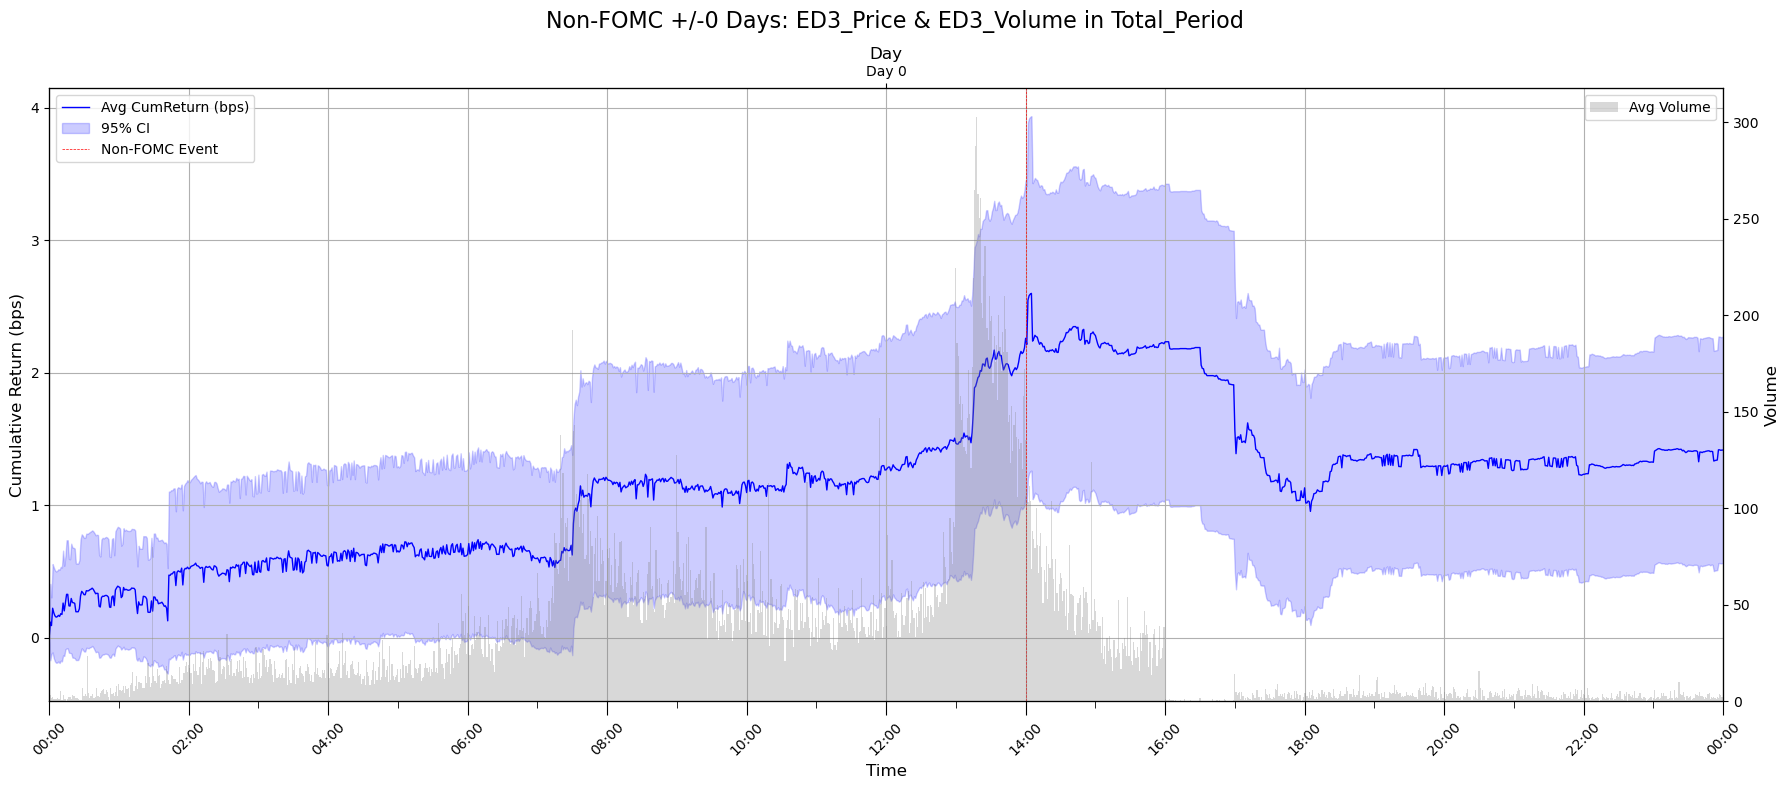

Saved CR table: ..\data\ED3\nonfomc\nonfomc_ED3_in_0_cr_Total.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_50680\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\ED3\nonfomc\nonfomc_ED3_k0_Total.xlsx
Saved LaTeX bundle: ..\data\ED3\nonfomc\latex\nonfomc_Total.tex


{'figure_path': WindowsPath('../data/ED3/nonfomc/nonfomc_fomc_window_k0_Total.png'),
 'cr_table_path': WindowsPath('../data/ED3/nonfomc/nonfomc_ED3_in_0_cr_Total.csv'),
 'daily_summary': {'table':                      FOMC_week_Day (-2)                              \
                                     Mean St. Dev P25 P50 P75 No. Obs   
  Avg Daily Volume                    NaN     NaN NaN NaN NaN     0.0   
  Diff_Vol (Ann - Day)                NaN     NaN NaN NaN NaN     NaN   
  # Obs                               0.0     NaN NaN NaN NaN     NaN   
  
                       FOMC_week_Day (-1)                  ...  \
                                     Mean St. Dev P25 P50  ...   
  Avg Daily Volume                    NaN     NaN NaN NaN  ...   
  Diff_Vol (Ann - Day)                NaN     NaN NaN NaN  ...   
  # Obs                               0.0     NaN NaN NaN  ...   
  
                       FOMC_week_Day (+1)                 FOMC_week_Day (+2)  \
                        

In [18]:
plot_fomc_k_window_enhanced(hft_input=hft_data, fomc_input=fomc_data,k=0, asset='ED3',period='Total',extra_metrics=None, fomc_type='nonfomc')


Skipping nonfomc event at 1997-09-10 14:15:00 due to invalid baseline price: 0.0.
Saved figure: ..\data\Emini\nonfomc\nonfomc_fomc_window_k2_Total.png


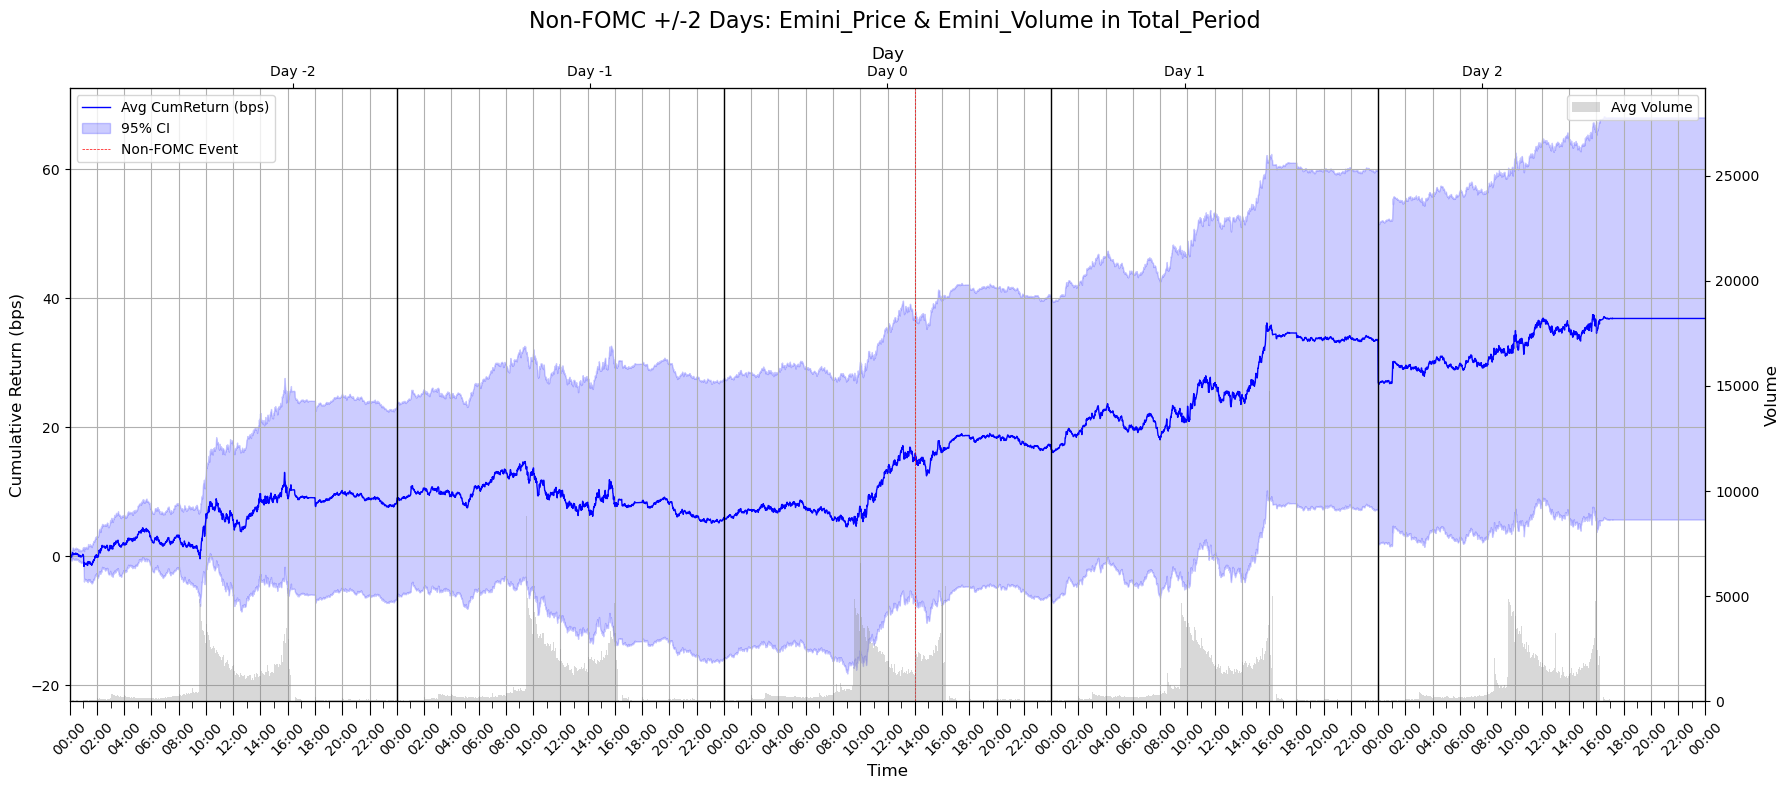

Saved CR table: ..\data\Emini\nonfomc\nonfomc_Emini_in_2_cr_Total.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_50680\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k2_Total.xlsx
Saved LaTeX bundle: ..\data\Emini\nonfomc\latex\nonfomc_Total.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_50680\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved extras (Count) workbook: ..\data\Emini\nonfomc\nonfomc_Emini_k2_Total_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\nonfomc\latex\nonfomc_Total_Count.tex


{'figure_path': WindowsPath('../data/Emini/nonfomc/nonfomc_fomc_window_k2_Total.png'),
 'cr_table_path': WindowsPath('../data/Emini/nonfomc/nonfomc_Emini_in_2_cr_Total.csv'),
 'daily_summary': {'table':                      FOMC_week_Day (-2)                                    \
                                     Mean        St. Dev      P25       P50   
  Avg Daily Volume          937531.577465  796510.355895  43807.0  960021.0   
  Diff_Vol (Ann - Day)      249692.201878            NaN      NaN       NaN   
  # Obs                        213.000000            NaN      NaN       NaN   
  
                                          FOMC_week_Day (-1)                \
                              P75 No. Obs               Mean       St. Dev   
  Avg Daily Volume      1461608.0   213.0       1.209989e+06  878847.20809   
  Diff_Vol (Ann - Day)        NaN     NaN      -2.376066e+04           NaN   
  # Obs                       NaN     NaN       2.130000e+02           NaN   
  
        

In [24]:
plot_fomc_k_window_enhanced(
    hft_input=emini_hft,
    fomc_input=non_fomc_data,
    k=2,
    asset='Emini',
    period='Total',
    extra_metrics={'Count': 'Emini_Count'},
    fomc_type='nonfomc'
)

Saved figure: ..\data\Emini\fomc_window_k2_Total.png


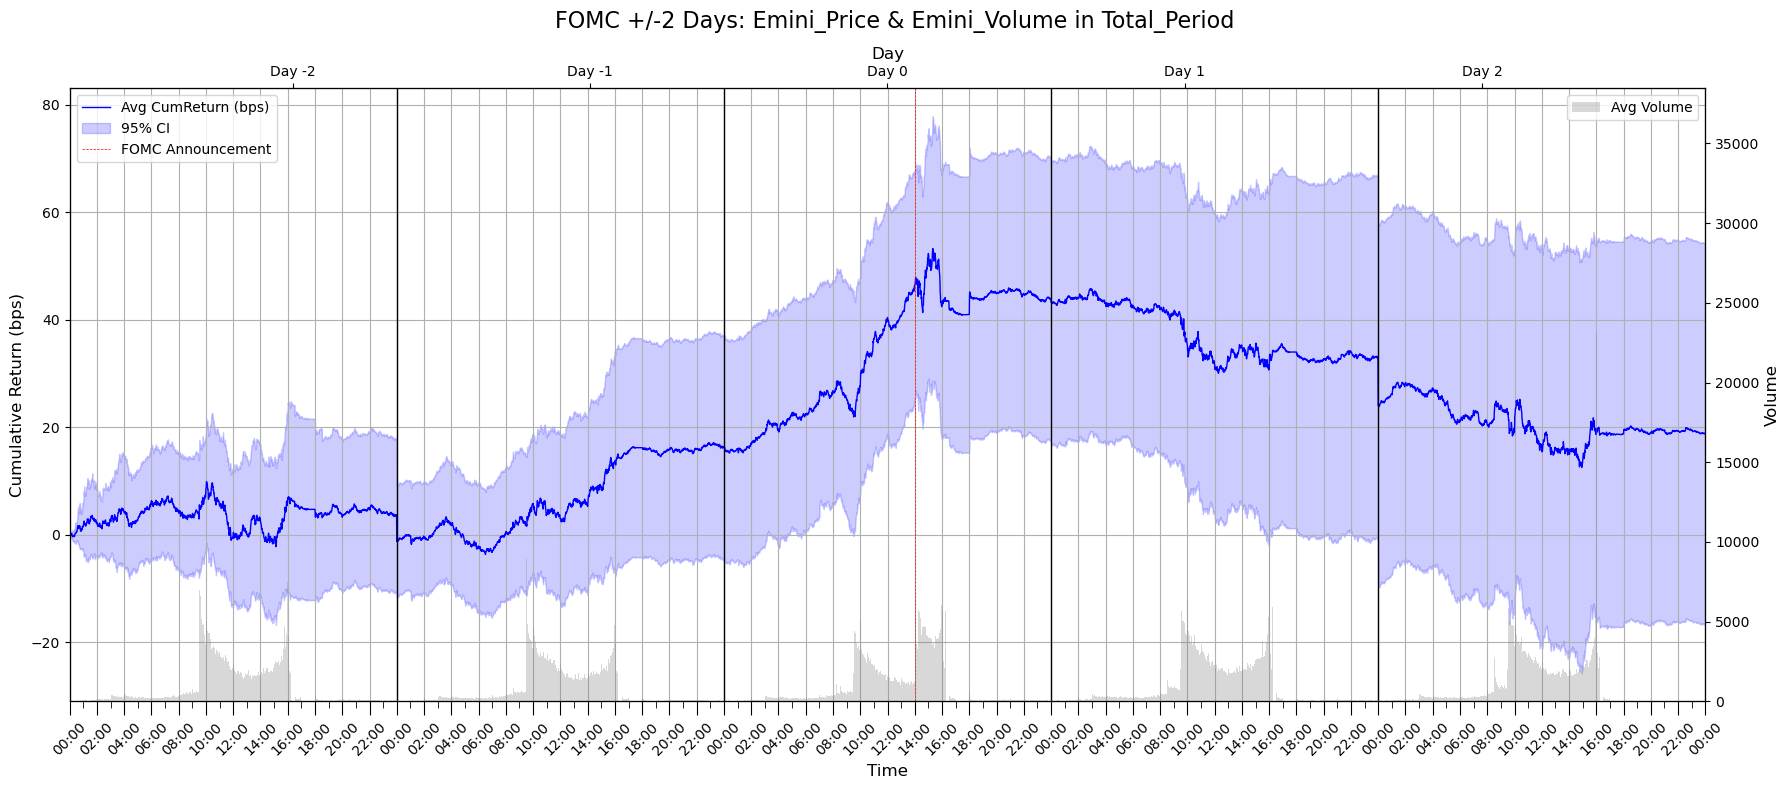

Saved CR table: ..\data\Emini\Emini_in_2_cr_Total.csv


C:\Users\galax\AppData\Local\Temp\ipykernel_50680\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved summary workbook: ..\data\Emini\Emini_k2_Total.xlsx
Saved LaTeX bundle: ..\data\Emini\latex\Total.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_50680\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\101934099.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df_wide.stack(dropna=False).reset_index()


Saved extras (Count) workbook: ..\data\Emini\Emini_k2_Total_Count.xlsx
Saved extras (Count) LaTeX: ..\data\Emini\latex\Total_Count.tex


{'figure_path': WindowsPath('../data/Emini/fomc_window_k2_Total.png'),
 'cr_table_path': WindowsPath('../data/Emini/Emini_in_2_cr_Total.csv'),
 'daily_summary': {'table':                      FOMC_week_Day (-2)                                    \
                                     Mean        St. Dev     P25        P50   
  Avg Daily Volume          902875.018182  864437.472796  2847.5  1003486.5   
  Diff_Vol (Ann - Day)      432622.045455            NaN     NaN        NaN   
  # Obs                        220.000000            NaN     NaN        NaN   
  
                                          FOMC_week_Day (-1)                 \
                              P75 No. Obs               Mean        St. Dev   
  Avg Daily Volume      1412161.5   220.0       1.162865e+06  955041.496641   
  Diff_Vol (Ann - Day)        NaN     NaN       1.723677e+05            NaN   
  # Obs                       NaN     NaN       2.200000e+02            NaN   
  
                                   

In [25]:
plot_fomc_k_window_enhanced(
    hft_input=emini_hft,
    fomc_input=fomc_data,
    k=2,
    asset='Emini',
    period='Total',
    extra_metrics={'Count': 'Emini_Count'},
    fomc_type='fomc'
)

##  Summary Tables ##

In [20]:
# Aggregate summary tables across assets

def load_asset_tables(asset, period='Total', k=2):
    safe_period = str(period).replace(' ', '_')
    excel_path = DATA_ROOT / asset / f'{asset}_k{k}_{safe_period}.xlsx'
    if not excel_path.exists():
        raise FileNotFoundError(f"Summary workbook not found: {excel_path}")
    daily = pd.read_excel(excel_path, sheet_name='daily volume', header=[0, 1], index_col=0)
    intraday = pd.read_excel(excel_path, sheet_name='intraday volume', header=[0, 1], index_col=0)
    daily.index.name = 'Statistic'
    intraday.index.name = 'Statistic'
    return daily, intraday

def aggregate_assets(assets, period='Total', k=2):
    daily_tables = []
    intraday_tables = []
    for asset in assets:
        daily, intraday = load_asset_tables(asset, period=period, k=k)
        daily_tables.append(daily)
        intraday_tables.append(intraday)
    daily_panel = pd.concat(daily_tables, keys=assets, names=['Asset', 'Statistic'])
    intraday_panel = pd.concat(intraday_tables, keys=assets, names=['Asset', 'Statistic'])
    return daily_panel, intraday_panel

bond_assets = ['FF1', 'FF2', 'ED2', 'ED3', 'ED4', '2yr', '5yr', '10yr']
emini_assets = ['Emini']

bond_daily_total, bond_intraday_total = aggregate_assets(bond_assets, period='Total', k=2)
emini_daily_total, emini_intraday_total = aggregate_assets(emini_assets, period='Total', k=2)

table1 = pd.concat(
    {
        'Panel A (Bond Futures)': bond_daily_total,
        'Panel B (E-mini Futures)': emini_daily_total,
    },
    names=['Panel', 'Asset', 'Statistic'],
)

table2 = pd.concat(
    {
        'Panel A (Bond Futures)': bond_intraday_total,
        'Panel B (E-mini Futures)': emini_intraday_total,
    },
    names=['Panel', 'Asset', 'Statistic'],
)

summary_dir = DATA_ROOT / 'summary_tables'
summary_dir.mkdir(parents=True, exist_ok=True)

table1_path = summary_dir / 'Table1_daily_volume_total.xlsx'
table2_path = summary_dir / 'Table2_intraday_volume_total.xlsx'

table1.to_excel(table1_path)
table2.to_excel(table2_path)

periods = ['Pre-ZLB', 'ZLB', 'Post-ZLB']
table3_daily = {}
table3_intraday = {}

for period in periods:
    bond_daily_p, bond_intraday_p = aggregate_assets(bond_assets, period=period, k=2)
    emini_daily_p, emini_intraday_p = aggregate_assets(emini_assets, period=period, k=2)
    table3_daily[period] = pd.concat(
        {
            'Panel A (Bond Futures)': bond_daily_p,
            'Panel B (E-mini Futures)': emini_daily_p,
        },
        names=['Panel', 'Asset', 'Statistic'],
    )
    table3_intraday[period] = pd.concat(
        {
            'Panel A (Bond Futures)': bond_intraday_p,
            'Panel B (E-mini Futures)': emini_intraday_p,
        },
        names=['Panel', 'Asset', 'Statistic'],
    )

with pd.ExcelWriter(summary_dir / 'Table3_volume_by_period.xlsx') as writer:
    for period in periods:
        table3_daily[period].to_excel(writer, sheet_name=f'{period}_daily')
        table3_intraday[period].to_excel(writer, sheet_name=f'{period}_intraday')

print('Table1 saved to', table1_path)
print('Table2 saved to', table2_path)
print('Table3 workbook saved to', summary_dir / 'Table3_volume_by_period.xlsx')



Table1 saved to ..\data\summary_tables\Table1_daily_volume_total.xlsx
Table2 saved to ..\data\summary_tables\Table2_intraday_volume_total.xlsx
Table3 workbook saved to ..\data\summary_tables\Table3_volume_by_period.xlsx


In [21]:

# Individual Tables and Latex
def flatten_for_output(table):
    df = table.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [' '.join(str(part) for part in col if str(part) != '') for col in df.columns.to_flat_index()]
    else:
        df.columns = [str(col) for col in df.columns]
    df = df.reset_index()
    df.columns = [str(col) for col in df.columns]
    return df

def export_table(table, subdir, basename, caption):
    out_dir = OUTPUT_ROOT / subdir
    out_dir.mkdir(parents=True, exist_ok=True)
    flat = flatten_for_output(table)
    excel_path = out_dir / f"{basename}.xlsx"
    flat.to_excel(excel_path, index=False)

    latex_df = flat.copy()
    numeric_cols = latex_df.select_dtypes(include='number').columns
    latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")
    latex_body = latex_df.to_latex(index=False, escape=False)
    latex_lines = [
        r"\begin{table}[!htbp]\centering",
        f"\caption{{{caption}}}",
        r"\small",
        latex_body,
        r"\end{table}",
    ]
    latex_content = "\n".join(latex_lines)

    latex_path = out_dir / f"{basename}.tex"
    latex_path.write_text(latex_content, encoding='utf-8')
    print('Saved', excel_path)
    print('Saved', latex_path)

export_table(table1, 'table1', 'Table1_daily_volume_total', 'Daily volume around FOMC (Total period)')
export_table(table2, 'table2', 'Table2_intraday_volume_total', 'Intraday volume around FOMC (Total period)')

periods = ['Pre-ZLB', 'ZLB', 'Post-ZLB']
for period in periods:
    export_table(
        table3_daily[period],
        'table3',
        f'Table3_{period}_daily_volume',
        f'Daily volume around FOMC ({period})'
    )
    export_table(
        table3_intraday[period],
        'table3',
        f'Table3_{period}_intraday_volume',
        f'Intraday volume around FOMC ({period})'
    )


Saved ..\output\table1\Table1_daily_volume_total.xlsx
Saved ..\output\table1\Table1_daily_volume_total.tex
Saved ..\output\table2\Table2_intraday_volume_total.xlsx
Saved ..\output\table2\Table2_intraday_volume_total.tex
Saved ..\output\table3\Table3_Pre-ZLB_daily_volume.xlsx
Saved ..\output\table3\Table3_Pre-ZLB_daily_volume.tex
Saved ..\output\table3\Table3_Pre-ZLB_intraday_volume.xlsx
Saved ..\output\table3\Table3_Pre-ZLB_intraday_volume.tex
Saved ..\output\table3\Table3_ZLB_daily_volume.xlsx
Saved ..\output\table3\Table3_ZLB_daily_volume.tex


<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\4175188649.py:25: SyntaxWarning: invalid escape sequence '\c'
  f"\caption{{{caption}}}",
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\4175188649.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\4175188649.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\4175188649.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\4175188649.p

Saved ..\output\table3\Table3_ZLB_intraday_volume.xlsx
Saved ..\output\table3\Table3_ZLB_intraday_volume.tex
Saved ..\output\table3\Table3_Post-ZLB_daily_volume.xlsx
Saved ..\output\table3\Table3_Post-ZLB_daily_volume.tex
Saved ..\output\table3\Table3_Post-ZLB_intraday_volume.xlsx
Saved ..\output\table3\Table3_Post-ZLB_intraday_volume.tex


C:\Users\galax\AppData\Local\Temp\ipykernel_50680\4175188649.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")
C:\Users\galax\AppData\Local\Temp\ipykernel_50680\4175188649.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  latex_df[numeric_cols] = latex_df[numeric_cols].applymap(lambda x: f"{x:,.3f}")


##  Stacked Plots ##

In [22]:
def plot_fomc_stacked_by_period_enhanced(asset='', k=1, hft_sets=None, fomc_sets=None, 
                                        extra_metrics=None, fomc_type='fomc'):
    """增强版按时期分析函数"""
    if fomc_type == 'fomc':
        default_hft_sets = {
            'Pre-ZLB': pre_zlb_hft,
            'ZLB': zlb_hft,
            'Post-ZLB': post_zlb_hft,
        }
        default_fomc_sets = {
            'Pre-ZLB': pre_zlb_fomc,
            'ZLB': zlb_fomc,
            'Post-ZLB': post_zlb_fomc,
        }
    else:  # nonfomc
        default_hft_sets = {
            'Pre-ZLB': pre_zlb_hft,
            'ZLB': zlb_hft,
            'Post-ZLB': post_zlb_hft,
        }
        default_fomc_sets = {
            'Pre-ZLB': pre_zlb_non_fomc,
            'ZLB': zlb_non_fomc,
            'Post-ZLB': post_zlb_non_fomc,
        }
    
    hft_map = hft_sets or default_hft_sets
    fomc_map = fomc_sets or default_fomc_sets

    results = {}
    for label, hft_df in hft_map.items():
        fomc_df = fomc_map.get(label, fomc_data if fomc_type == 'fomc' else non_fomc_data)
        res = plot_fomc_k_window_enhanced(
            hft_input=hft_df,
            fomc_input=fomc_df,
            k=k,
            asset=asset,
            period=label,
            extra_metrics=extra_metrics,
            fomc_type=fomc_type,
        )
        results[label] = res
    return results

### ========== Periodic Price/Volume Report ==========
We have 
Pre-ZLB, ZLB, Post-ZLB
Then run：
```python
plot_fomc_stacked_by_period('FF1', k=1)
```


In [ ]:
plot_fomc_stacked_by_period_enhanced(
    asset='Emini',
    k=2,
    hft_sets={
        'Pre-ZLB': pre_zlb_emini,
        'ZLB': zlb_emini,
        'Post-ZLB': post_zlb_emini,
    },
    fomc_sets={
        'Pre-ZLB': pre_zlb_fomc,
        'ZLB': zlb_fomc,
        'Post-ZLB': post_zlb_fomc,
    },
    extra_metrics={'Count': 'Emini_Count'},
)


NameError: name 'plot_fomc_stacked_by_period' is not defined

In [ ]:
plot_fomc_stacked_by_period(asset='FF1', k=2)
plot_fomc_stacked_by_period(asset='FF2', k=2)
plot_fomc_stacked_by_period(asset='ED2', k=2)
plot_fomc_stacked_by_period(asset='ED3', k=2)
plot_fomc_stacked_by_period(asset='ED4', k=2)
plot_fomc_stacked_by_period(asset='2yr', k=2)
plot_fomc_stacked_by_period(asset='5yr', k=2)
plot_fomc_stacked_by_period(asset='10yr', k=2)